# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import seaborn as sns
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import optuna

# Datasets

In [2]:
CTGData=pd.read_csv('CTGPattern selected 20 features.csv')
CTGData.head()

,LB,AC,FM,UC,DL,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,label
0,120,0.000000,0.0,0.000000,0.000000,0.0,73,0.5,43,2.4,...,62,126,2,0,120,137,121,73,1,8
1,132,0.006380,0.0,0.006380,0.003190,0.0,17,2.1,0,10.4,...,68,198,6,1,141,136,140,12,0,5
2,133,0.003322,0.0,0.008306,0.003322,0.0,16,2.1,0,13.4,...,68,198,5,1,141,135,138,13,0,5
3,134,0.002561,0.0,0.007682,0.002561,0.0,16,2.4,0,23.0,...,53,170,11,0,137,134,137,13,1,5
4,132,0.006515,0.0,0.008143,0.000000,0.0,16,2.4,0,19.9,...,53,170,9,0,137,136,138,11,1,1


<AxesSubplot:xlabel='label', ylabel='count'>

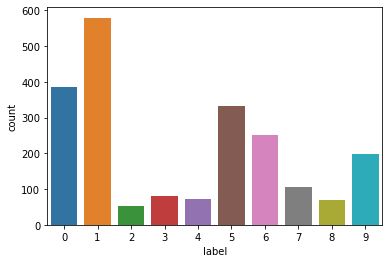

In [3]:
sns.countplot(x='label',data=CTGData)

# Build the model

In [4]:
CTGData.shape

(2126, 21)

In [5]:
CTGData01=CTGData.copy()

In [6]:
X1=CTGData01.drop(labels=['label'],axis=1)

y1=CTGData01['label'].values


In [7]:
#stanardilization

scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)

### Artificial Neural Network

Load data

In [8]:
#split train dataset and test dataset
X1_train, X1_test,y1_train,y1_test= train_test_split(X1,y1,test_size=0.2, shuffle = True,stratify=y1,random_state=42)
print("X_train.shape :",X1_train.shape)
print("X_test.shape :",X1_test.shape)
# print(X_train.head())


X_train.shape : (1700, 20)
X_test.shape : (426, 20)


Define the dataset

In [9]:

X1_train = torch.from_numpy(X1_train)
y1_train = torch.from_numpy(y1_train ).type(torch.LongTensor)

X1_test  = torch.from_numpy(X1_test )
y1_test= torch.from_numpy(y1_test).type(torch.LongTensor)

batch_size = 128

train = torch.utils.data.TensorDataset(X1_train, y1_train )
test = torch.utils.data.TensorDataset(X1_test , y1_test)


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

Define the Optuna  model

In [10]:

# Build a model by implementing define-by-run design from Optuna
def build_model_custom(trial):
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 20
# looping to determine the number of layers and nodes in each layer     
    for i in range(n_layers):
#         the number of nodes in each layer.
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        
#         p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
#         layers.append(nn.Dropout(p))
        
        in_features = out_features
        
    layers.append(nn.Linear(in_features, 10))
#     layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)

# Train and evaluate the accuracy of neural network with the addition of pruning mechanism
def train_and_evaluate(param, model, trial):
    


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in train_loader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in test_loader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            accuracy = total_acc_val/len(test)
            
            # Add prune mechanism
            trial.report(accuracy, epoch_num)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return accuracy
  
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }
    
    model = build_model_custom(trial)

    accuracy = train_and_evaluate(params, model, trial)

    return accuracy
  
EPOCHS = 30
    
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)



[I 2022-09-09 14:07:43,189] A new study created in memory with name: no-name-a1562df3-ddad-4011-911e-a5da369b6b8c
C:\Users\COOLER~1\AppData\Local\Temp/ipykernel_20272/2944855679.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[I 2022-09-09 14:07:43,916] Trial 0 finished with value: 0.42018779342723006 and parameters: {'learning_rate': 0.001923483972490575, 'optimizer': 'SGD', 'n_layers': 1, 'n_units_l0': 88}. Best is trial 0 with value: 0.42018779342723006.
[I 2022-09-09 14:07:44,902] Trial 1 finished with value: 0.27230046948356806 and parameters: {'learning_rate': 0.09734613468807915, 'optimizer': 'RMSprop', 'n_layers': 3, 'n_units_l0': 119, 'n_units_l1': 79, 'n_units_l2': 7}. Best is trial 0 with value: 0.42018779342723006.
[I 2022-09-0

In [11]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.018016879806179577
optimizer: Adam
n_layers: 1
n_units_l0: 128


In [12]:
# # Best is trial 3 with value:  0.8826291079812206
# learning_rate: 0.018016879806179577
# optimizer: Adam
# n_layers: 1
# n_units_l0: 128




In [13]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


In [14]:
epochs =30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X1.shape[1]
hidden_dim1 = 104 #hidden layer1
hidden_dim2 = 102 #hidden layer2 
output_dim = len(set(y1))

In [15]:
model = ANNModel(input_dim, hidden_dim1,hidden_dim2,output_dim)


learning_rate =  0.0222
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [16]:
start=datetime.now()
total_step = len(train_loader)
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []
  # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(train_loader):
        train_data_batch = train_data_batch.float().to(device) #from double to float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch)
        # print(loss)
        #backword propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # accumulate the loss of each step 
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())
        # tot_acc += (outputs.argmax(dim=1) == train_label_batch).sum().item()
        sklearn_accuracy = accuracy_score(train_trues, train_preds)
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        print("[sklearn_metrics] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch, tot_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
stop=datetime.now()
execution_time_ann=(stop-start)
training_time_ann='%.4f'%(execution_time_ann).total_seconds()
print(training_time_ann)
        
test_preds = []
test_trues = []
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(test_loader):
        test_data_batch = test_data_batch.float().to(device) #from double to float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        probs = F.softmax(test_outputs, dim=1) 
        test_outputs = test_outputs.argmax(dim=1)
        testloss = criterion(probs, test_data_label)
#         preds = torch.argmax(logits, dim=1)
        test_preds.extend(test_outputs.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='micro')
        sklearn_recall = recall_score(test_trues, test_preds, average='micro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
        print(classification_report(test_trues, test_preds))
        conf_matrix = confusion_matrix(test_trues, test_preds)
        print(conf_matrix)
#         plot_confusion_matrix(conf_matrix)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

[sklearn_metrics] Epoch:0 loss:2.3294 accuracy:0.0469 precision:0.0469 recall:0.0469 f1:0.0469
[sklearn_metrics] Epoch:0 loss:4.1715 accuracy:0.2500 precision:0.2500 recall:0.2500 f1:0.2500
[sklearn_metrics] Epoch:0 loss:5.8976 accuracy:0.2917 precision:0.2917 recall:0.2917 f1:0.2917
[sklearn_metrics] Epoch:0 loss:7.5092 accuracy:0.3379 precision:0.3379 recall:0.3379 f1:0.3379
[sklearn_metrics] Epoch:0 loss:8.8938 accuracy:0.3781 precision:0.3781 recall:0.3781 f1:0.3781
[sklearn_metrics] Epoch:0 loss:10.1256 accuracy:0.4180 precision:0.4180 recall:0.4180 f1:0.4180
[sklearn_metrics] Epoch:0 loss:11.2774 accuracy:0.4297 precision:0.4297 recall:0.4297 f1:0.4297
[sklearn_metrics] Epoch:0 loss:12.2488 accuracy:0.4688 precision:0.4688 recall:0.4688 f1:0.4688
[sklearn_metrics] Epoch:0 loss:13.2030 accuracy:0.4905 precision:0.4905 recall:0.4905 f1:0.4905
[sklearn_metrics] Epoch:0 loss:14.1869 accuracy:0.5023 precision:0.5023 recall:0.5023 f1:0.5023
[sklearn_metrics] Epoch:0 loss:15.2392 accura

[sklearn_metrics] Epoch:6 loss:2.4053 accuracy:0.8424 precision:0.8424 recall:0.8424 f1:0.8424
[sklearn_metrics] Epoch:6 loss:2.7818 accuracy:0.8460 precision:0.8460 recall:0.8460 f1:0.8460
[sklearn_metrics] Epoch:6 loss:3.1098 accuracy:0.8477 precision:0.8477 recall:0.8477 f1:0.8477
[sklearn_metrics] Epoch:6 loss:3.4589 accuracy:0.8490 precision:0.8490 recall:0.8490 f1:0.8490
[sklearn_metrics] Epoch:6 loss:3.8007 accuracy:0.8484 precision:0.8484 recall:0.8484 f1:0.8484
[sklearn_metrics] Epoch:6 loss:4.2493 accuracy:0.8487 precision:0.8487 recall:0.8487 f1:0.8487
[sklearn_metrics] Epoch:6 loss:4.6864 accuracy:0.8483 precision:0.8483 recall:0.8483 f1:0.8483
[sklearn_metrics] Epoch:6 loss:5.0986 accuracy:0.8486 precision:0.8486 recall:0.8486 f1:0.8486
[sklearn_metrics] Epoch:6 loss:5.3755 accuracy:0.8482 precision:0.8482 recall:0.8482 f1:0.8482
[sklearn_metrics] Epoch:7 loss:0.3607 accuracy:0.8359 precision:0.8359 recall:0.8359 f1:0.8359
[sklearn_metrics] Epoch:7 loss:0.7550 accuracy:0.8

[sklearn_metrics] Epoch:12 loss:2.1737 accuracy:0.9149 precision:0.9149 recall:0.9149 f1:0.9149
[sklearn_metrics] Epoch:12 loss:2.5623 accuracy:0.9102 precision:0.9102 recall:0.9102 f1:0.9102
[sklearn_metrics] Epoch:12 loss:2.9361 accuracy:0.9070 precision:0.9070 recall:0.9070 f1:0.9070
[sklearn_metrics] Epoch:12 loss:3.1804 accuracy:0.9069 precision:0.9069 recall:0.9069 f1:0.9069
[sklearn_metrics] Epoch:12 loss:3.3993 accuracy:0.9075 precision:0.9075 recall:0.9075 f1:0.9075
[sklearn_metrics] Epoch:12 loss:3.6603 accuracy:0.9076 precision:0.9076 recall:0.9076 f1:0.9076
[sklearn_metrics] Epoch:13 loss:0.2458 accuracy:0.9141 precision:0.9141 recall:0.9141 f1:0.9141
[sklearn_metrics] Epoch:13 loss:0.6700 accuracy:0.8906 precision:0.8906 recall:0.8906 f1:0.8906
[sklearn_metrics] Epoch:13 loss:1.0091 accuracy:0.8802 precision:0.8802 recall:0.8802 f1:0.8802
[sklearn_metrics] Epoch:13 loss:1.2314 accuracy:0.8867 precision:0.8867 recall:0.8867 f1:0.8867
[sklearn_metrics] Epoch:13 loss:1.5064 a

[sklearn_metrics] Epoch:18 loss:3.1152 accuracy:0.9177 precision:0.9177 recall:0.9177 f1:0.9177
[sklearn_metrics] Epoch:18 loss:3.5273 accuracy:0.9165 precision:0.9165 recall:0.9165 f1:0.9165
[sklearn_metrics] Epoch:19 loss:0.1900 accuracy:0.9297 precision:0.9297 recall:0.9297 f1:0.9297
[sklearn_metrics] Epoch:19 loss:0.2997 accuracy:0.9492 precision:0.9492 recall:0.9492 f1:0.9492
[sklearn_metrics] Epoch:19 loss:0.5972 accuracy:0.9271 precision:0.9271 recall:0.9271 f1:0.9271
[sklearn_metrics] Epoch:19 loss:0.8562 accuracy:0.9238 precision:0.9238 recall:0.9238 f1:0.9238
[sklearn_metrics] Epoch:19 loss:1.0743 accuracy:0.9219 precision:0.9219 recall:0.9219 f1:0.9219
[sklearn_metrics] Epoch:19 loss:1.2236 accuracy:0.9232 precision:0.9232 recall:0.9232 f1:0.9232
[sklearn_metrics] Epoch:19 loss:1.4404 accuracy:0.9219 precision:0.9219 recall:0.9219 f1:0.9219
[sklearn_metrics] Epoch:19 loss:1.6700 accuracy:0.9219 precision:0.9219 recall:0.9219 f1:0.9219
[sklearn_metrics] Epoch:19 loss:1.9418 a

[sklearn_metrics] Epoch:26 loss:0.1842 accuracy:0.9297 precision:0.9297 recall:0.9297 f1:0.9297
[sklearn_metrics] Epoch:26 loss:0.3419 accuracy:0.9336 precision:0.9336 recall:0.9336 f1:0.9336
[sklearn_metrics] Epoch:26 loss:0.4843 accuracy:0.9427 precision:0.9427 recall:0.9427 f1:0.9427
[sklearn_metrics] Epoch:26 loss:0.8922 accuracy:0.9180 precision:0.9180 recall:0.9180 f1:0.9180
[sklearn_metrics] Epoch:26 loss:1.1338 accuracy:0.9156 precision:0.9156 recall:0.9156 f1:0.9156
[sklearn_metrics] Epoch:26 loss:1.3095 accuracy:0.9206 precision:0.9206 recall:0.9206 f1:0.9206
[sklearn_metrics] Epoch:26 loss:1.4724 accuracy:0.9185 precision:0.9185 recall:0.9185 f1:0.9185
[sklearn_metrics] Epoch:26 loss:1.7440 accuracy:0.9170 precision:0.9170 recall:0.9170 f1:0.9170
[sklearn_metrics] Epoch:26 loss:2.0839 accuracy:0.9141 precision:0.9141 recall:0.9141 f1:0.9141
[sklearn_metrics] Epoch:26 loss:2.4166 accuracy:0.9148 precision:0.9148 recall:0.9148 f1:0.9148
[sklearn_metrics] Epoch:26 loss:2.7405 a

In [17]:
training_time_ann

'3.2154'